## Population prior

In this notebook, we will sample the Madau-Dickinson star formation rate profile,

$$ \Psi(z) \propto \frac{(1+z)^\alpha}{1 + [(1+z)/c]^\beta},$$

using the inversion technique, wherein the CDF percentiles are sampled from a uniform distribution and inverted to yield an histogram over $z$. The function $\Psi$ will be normalized for an easier comparison with the histogram.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from inference.utils import normalize, merger_rate, sample_from_func, EventGenerator
from inference.prior import UniformPrior
from inference.likelihood import DrawnGWMergerRatePriorInference

In [2]:
n = 1000
bins = 50
z = np.linspace(1e-4, 20, n)
md_args = (2.7, 5.6, 2.9)
md_merger_rate = normalize(merger_rate(z, *md_args), z)
samples = sample_from_func(n, merger_rate, z, *md_args)

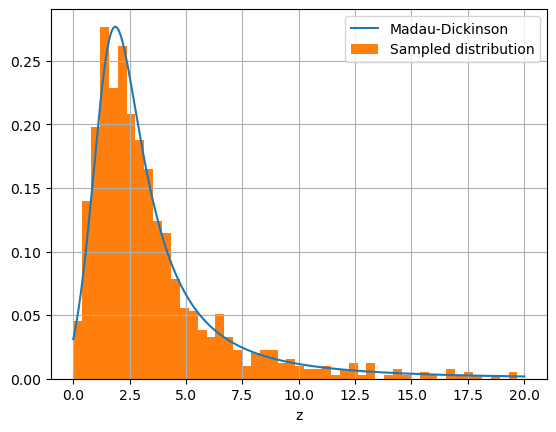

In [3]:
plt.plot(z, md_merger_rate, label='Madau-Dickinson')
plt.hist(samples, bins=bins, density=True, label="Sampled distribution")
plt.xlabel('z')
plt.legend()
plt.grid()
plt.show()

The full posterior distribution for mergers given a rate distribution on redshift proportional to the star formation rate is given by 

$$ p(\Lambda) \propto \pi (\Lambda) \xi(\Lambda)^{-N_\text{det}}\prod_{i=1}^{N_\text{det}} \int p(\hat{d}_L | d_L(z, H_0))p(z|\Lambda)dz,$$
with
$$ p(z | \Lambda) = \frac{1}{1 + z} \frac{dV_c}{dz} \mathcal{R}(z),$$
where $dV_c /dz$ is the differential comoving volume, $\mathcal{R}(z)$ is the merger rate per comoving volume at $z$ (which we assume proportional to the SFR) and the $(1+z)^{-1}$ factor accounts for the translation between detector frame and source frame.

The corresponding likelihood is implemented in the `DrawnGWMergerRatePriorInference` class. Let us plot some contours as a sanity check:

In [4]:
fiducial_H0 = 70
sigma_dl = 0.1
prior = UniformPrior(prior_min=np.array([20, -10.0, 0.0, 1.0]), prior_max=np.array([140, 10.0, 10.0, 10.0]))
inference = DrawnGWMergerRatePriorInference(
        z,
        prior,
        fiducial_H0=fiducial_H0,
        sigma_dl=sigma_dl,
        low_redshift=False,
    )
cosmology = inference.fiducial_cosmology

14 events were generated


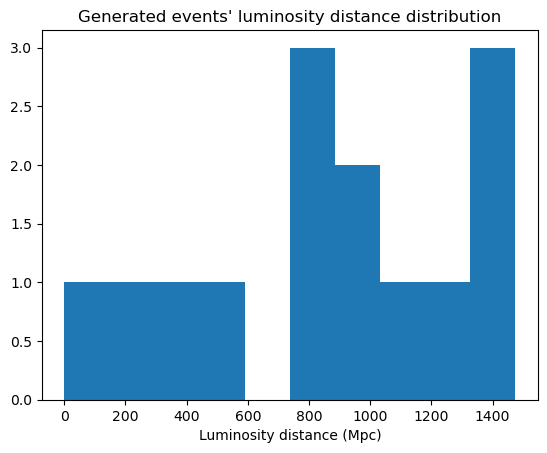

In [5]:
events = EventGenerator(fiducial_H0).from_redshifts(cosmology, samples, sigma_dl)
print(f"{len(events)} events were generated")
plt.hist(events)
plt.title("Generated events' luminosity distance distribution")
plt.xlabel('Luminosity distance (Mpc)')
plt.show()

[[70.          2.7         5.6         2.9       ]
 [72.72246771  5.6629357   5.70143669  3.99308348]
 [62.56852568 -0.92459077  5.34209183  3.62636778]
 [50.35888384  3.88440971  5.49573971  3.28573001]
 [62.00354599  4.89409444  5.01111808  2.50242612]
 [64.74847972  2.53293883  5.53239008  1.77207444]]


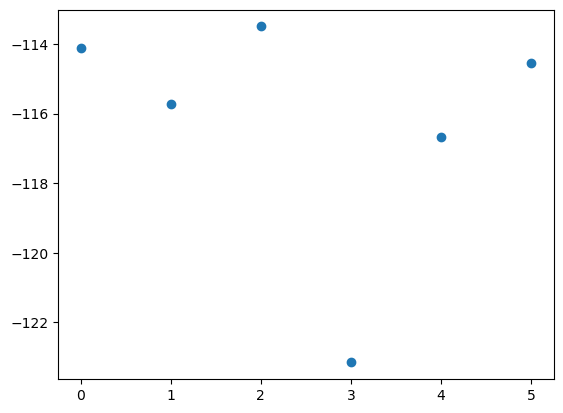

In [6]:
n_plots = 5
fiducial_params = np.array([fiducial_H0, *md_args])
fluctuations = fiducial_params + 1e-1 * prior.interval * np.random.standard_normal((5, len(fiducial_params)))
fluctuations = np.vstack((fiducial_params, fluctuations))
print(fluctuations)
plt.scatter(np.arange(n_plots + 1), [inference.log_posterior(params, events, z) for params in fluctuations])
plt.show()